# Machine Learning Interatomic Potentials with Metatensor

This notebook contains a short example of how one can train a very simple MLIP
using metatensor to pass data around. 

**WARNING**: To ensure a reasonable training time, the dataset size, model
complexity and training procedure have been reduced to their absolute minimum.
If you want to train a model for your own research, make sure you evaluate all
of these and increase them to ensure the resulting MLIP is stable and precise.

In general, when training a MLIP we need the following ingredients:

- a dataset, containing structures and their energy (and forces/virial). Here we
  will use a dataset of conformers of Ethanol, with the energy and forces
  computed using [DFTB](https://dftbplus.org/).
- a model architecture, which defines how our MLIP makes its predictions. Here
  we'll use a perceptron neural network on top of rotation invariants SOAP power
  spectrum. This should be very close to the first generation of
  Behler-Parrinello NNs.
- an optimizer and loss function, used inside a training loop to optimize the NN
  weights and ensure the model predictions match the DFTB calculations.

## 1 - The Dataset

The dateset we will use contains a collection of distorted Ethanol
conformations, taken from the ANI-1 dataset (see
https://github.com/isayev/ANI1_dataset) with their energies and forces
re-computed using DFTB+ (see https://dftbplus.org).

In [1]:
import numpy as np

import ase.io  # read the dataset

import chemiscope  # display the structures and associated properties in jupyter


In [2]:
# Read the data and extract energies and forces from ASE
frames = ase.io.read("../ethanol_conformers_dftb.xyz", ":500")

energies = np.array([[f.info["energy"]] for f in frames])
forces = np.vstack([f.arrays["forces"] for f in frames])


We can use chemiscope (https://chemiscope.org/) to visualize the structures and
corresponding energies in this dataset.

In [3]:
chemiscope.show(frames, properties={
    "frame_index": np.arange(len(frames)),
    "energy": energies,
})


ChemiscopeWidget(value='{"meta": {"name": " "}, "structures": [{"size": 10, "names": ["O", "C", "C", "C", "H",…

## 2 - The Model

Our model will be built using a basic neural network applied on top of SOAP
power spectrum, as computed by rascaline (https://github.com/Luthaf/rascaline/).

TODO: basic SOAP intro

In [4]:
from typing import Dict, List, Optional

import torch

torch.manual_seed(123456)

import matplotlib.pyplot as plt

import rascaline.torch
from rascaline.torch import AtomicComposition, SoapPowerSpectrum, systems_to_torch

from metatensor.torch import Labels, TensorBlock


As customary when using PyTorch, our model will be a class inheriting from
`torch.nn.Module`. In the `forward` function, we'll take a
`rascaline.torch.System`, compute the SOAP power spectrum for all atoms in the
system and then send this representation through a neural network. This will
give us per-atom energies, that we will then sum together to get the overall
prediction.

$$
E = \sum_i NN(\text{SOAP}_i)
$$

The same NN will be used regardless of the central atom species (this will be a
first possible improvement of this model later!).

In [5]:
class EthanolModel(torch.nn.Module):
    def __init__(self, soap_parameters, species, energy_offset):
        super().__init__()

        self.energy_offset = torch.tensor(energy_offset)
        self.species = species

        self.soap_calculator = SoapPowerSpectrum(**soap_parameters)
        self.species_pairs = torch.IntTensor(
            [(i, j) for i in species for j in species if i <= j]
        )

        # Number of features produced by the SOAP calculator,
        # i.e. size of the input of the NN
        n_soap = (
            (soap_parameters["max_angular"] + 1)
            * soap_parameters["max_radial"] ** 2
            * len(self.species_pairs)
        )

        # Definition of our NN: one hidden layer,
        # SiLU activation, 128-sized latent space
        self.soap_nn = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=n_soap, out_features=128, bias=False, dtype=torch.float64
            ),
            torch.nn.SiLU(),
            torch.nn.Linear(
                in_features=128, out_features=128, bias=False, dtype=torch.float64
            ),
            torch.nn.SiLU(),
            torch.nn.Linear(
                in_features=128, out_features=1, bias=True, dtype=torch.float64
            ),
        )

    def forward(
        self,
        systems: List[rascaline.torch.System],
        selected_samples: Optional[Labels] = None,
    ):
        energies = torch.zeros((len(systems), 1), dtype=torch.float64)
        for i, system in enumerate(systems):
            soap = self.soap_calculator([system], selected_samples=selected_samples)
            soap = soap.keys_to_properties(
                Labels(["species_neighbor_1", "species_neighbor_2"], self.species_pairs)
            )
            soap = soap.keys_to_samples("species_center")

            energies_per_atom = self.soap_nn(soap.block().values)
            energies[i] = energies_per_atom.sum()

        return energies + self.energy_offset


Let's create our model!

To simplify the task of the NN, we will enforce a constant energy offset
corresponding to some arbitrary energy baseline (here, the mean energy of the
training set). 

| ![TASK](../images/clipboard.png) | Go back to the class definition above, and add the energy offset to the prediction |
|-------------------------------|------------------------------------------------------------------------------------|

In [6]:
SOAP_PARAMETERS = {
    "cutoff": 3.5,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.3,
    "center_atom_weight": 1.0,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
}

energy_offset = energies.mean()
model = EthanolModel(
    SOAP_PARAMETERS,
    species=[1, 6, 8],
    energy_offset=energy_offset,
)


first_energy = model(systems_to_torch(frames[:1]))
if torch.abs(first_energy + 290) > 1:
    raise Exception(
        f"energy of the first structure is {first_energy.item()}, should be around -290."
        "Please modify the class above!"
    )


Now we can create the tools to train the model:

In [7]:
# Let's start with the inputs (systems) and expected outputs (reference_energies) of our model

# systems_to_torch convert anything rascaline accepts as input (which includes
# `ase.Atoms`) to a class compatible with Torch and TorchScript
systems = systems_to_torch(frames)

reference_energies = torch.tensor(energies)

# We'll need a loss to compare the prediction to the actual output of the model
# let's use the mean square error loss
mse_loss = torch.nn.MSELoss()

# the optimizer updates the weights of the model according to the gradients
# a learning rate of 0.003 allows to learn fast enough while preventing the model
# from jumping around in parameter space
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003)
epoch = 0


We can now run the training! We might have to run the loop multiple times to
ensure we reach an OK accuracy. As a starting point, we'll stop with a loss
around 0.025, but feel free to come back and try to get the loss even lower!


| ![TASK](../images/clipboard.png) | Run the training loop until the loss is below 0.025 |
|-------------------------------|-----------------------------------------------------|

In [8]:
for epoch in range(epoch, epoch + 100 + 1):
    optimizer.zero_grad()  # set all parameters gradients to zero

    predicted_energies = model(systems)  # run the model once

    loss = mse_loss(predicted_energies, reference_energies)  # compute a loss
    print(f"loss at epoch {epoch} is", loss.item())

    loss.backward()  # backward propagate from the loss, updating all parameters gradients
    optimizer.step()  # run one optimizer step, updating the parameters based on gradients


loss at epoch 0 is 0.9703145406196505
loss at epoch 1 is 0.6491661842854746
loss at epoch 2 is 0.5015819180387454
loss at epoch 3 is 0.6548438851107978
loss at epoch 4 is 0.529129037790011
loss at epoch 5 is 0.49644093042783133
loss at epoch 6 is 0.561332893665143
loss at epoch 7 is 0.5512777408388755
loss at epoch 8 is 0.49548387244230435
loss at epoch 9 is 0.4705544384253893
loss at epoch 10 is 0.4904599192231157
loss at epoch 11 is 0.5052021457345587
loss at epoch 12 is 0.48578770840824304
loss at epoch 13 is 0.4589086925843338
loss at epoch 14 is 0.4506434232606783
loss at epoch 15 is 0.45760797498658784
loss at epoch 16 is 0.46168537908074886
loss at epoch 17 is 0.4523176889359301
loss at epoch 18 is 0.43398137188792124
loss at epoch 19 is 0.41864719677671236
loss at epoch 20 is 0.4133853967187798
loss at epoch 21 is 0.41181752697929186
loss at epoch 22 is 0.4009226178989465
loss at epoch 23 is 0.37979299204089123
loss at epoch 24 is 0.3609941383178342
loss at epoch 25 is 0.351343

In [9]:
if loss.item() > 0.025:
    raise Exception(
        f"loss is still too high, please continue running the training loop"
    )


We can now check the energy prediction we are making against the reference
values.

In an actual research setting, you would also want to check the predictions your
model is making on a validation/hold-out set of structure, to prevent your model
from over-fitting your training set.

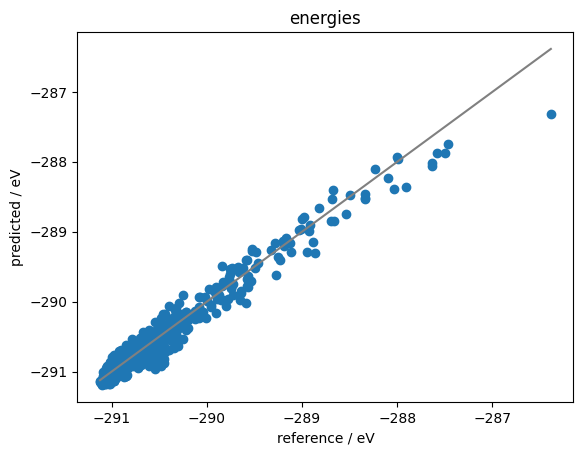

In [10]:
predicted_energy = model(systems)

plt.scatter(energies, predicted_energy.detach().numpy())

x = [np.min(energies), np.max(energies)]
plt.plot(x, x, c="grey")

plt.title("energies")
plt.xlabel("reference / eV")
plt.ylabel("predicted / eV")
plt.show()


All the code in rascaline and metatensor is fully integrated with torch
automatic differentiation framework, which allows to compute the gradients of
any output with respect to any input. In particular, we can use this to also
predict the forces acting on the system:

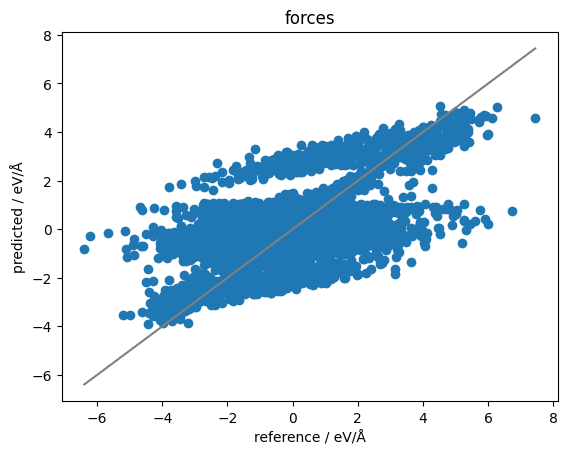

In [11]:
# Convert to `rascaline.torch.System`, but now tracking
# gradients with respect to positions
systems_positions_grad = systems_to_torch(frames, positions_requires_grad=True)

# make a new prediction
predicted_energy = model(systems_positions_grad)

# extract the gradient of the prediction with backward propagation
# using `torch.autograd.grad`
predicted_forces = torch.autograd.grad(
    outputs=predicted_energy,
    inputs=[s.positions for s in systems_positions_grad],
    grad_outputs=-torch.ones_like(predicted_energy),
    create_graph=False,
    retain_graph=False,
)
predicted_forces = torch.vstack(predicted_forces)

plt.scatter(forces.flatten(), predicted_forces.detach().numpy().flatten())

x = [np.min(forces.flatten()), np.max(forces.flatten())]
plt.plot(x, x, c="grey")

plt.title("forces")
plt.xlabel("reference / eV/Å")
plt.ylabel("predicted / eV/Å")
plt.show()


## Exporting the model

Now that we have a reasonable model, let's export it! We'll need to define some
metadata about out model as well, so the MD engine can know which units
conversion to make and what the model can do.

In [12]:
from typing import Dict

from rascaline.torch import metatensor_system_to_rascaline

from metatensor.torch.atomistic import MetatensorAtomisticModule
from metatensor.torch.atomistic import System as MetatensorSystem
from metatensor.torch.atomistic import ModelOutput, ModelCapabilities, ModelRunOptions


We'll need a class conforming to the `MetatensorAtomisticModule` API. In this
API, the model receive as input a single structure and a set of options,
including which outputs the engine needs. The model should then return these
outputs in a dictionary of `TensorBlock`.

In [13]:
class ExportWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        # model we are wrapping
        self.model = model

    def forward(
        self,
        system: MetatensorSystem,
        run_options: ModelRunOptions,
    ) -> Dict[str, TensorBlock]:
        # check if the energy was even required
        if "energy" not in run_options.outputs:
            return {}

        # `run_options.selected_atoms` is used to select a subset of atoms on which the
        # model should run. This is used in particular for domain decomposition, where
        # the model should only produce an energy for the atoms in the current domain.
        selected_atoms = run_options.selected_atoms
        if selected_atoms is None:
            selected_samples = None
        else:
            # If the engine selected some atoms, we pass these as
            # selected samples to rascaline
            selected_samples = Labels(
                "center", torch.IntTensor(selected_atoms).reshape(-1, 1)
            )

        # Run the model
        energy = self.model(
            metatensor_system_to_rascaline(system),
            selected_samples=selected_samples,
        )

        # Return our prediction in a Dict[str, TensorBlock]. Here there is'nt much
        # metatdata to attach to the output, but this will change if we are returning
        # per-atom energy, or more complex outputs (dipôle moments, electronic density,
        # etc.)
        return {
            "energy": TensorBlock(
                values=energy.reshape(1, 1),
                samples=Labels("_", torch.IntTensor([[0]])),
                components=[],
                properties=Labels("energy", torch.IntTensor([[0]])),
            )
        }


In [14]:
# Wrap the model in our export wrapper
wrapper = ExportWrapper(model)
wrapper = wrapper.eval()


The final step before exporting our model is to define its capabilities: what
can this model compute; what are the expected inputs, etc.

In [15]:
# our model has a single output: the energy
energy_output = ModelOutput(
    quantity="energy",
    # energy is returned in eV
    unit="eV",
    # energy is returned globally, not per-atom
    per_atom=False,
)

# overall capabilities of the model
capabilities = ModelCapabilities(
    # expected unit for the positions and cell vectors
    length_unit="angstrom",
    # which species can this model work with
    species=model.species,
    outputs={
        "energy": energy_output,
    },
)


Finally, we can export our model and it's capabilities as a new
`MetatensorAtomisticModule`, which will run a couple of checks on the model and
handle all the units conversions.

In [16]:
metatensor_model = MetatensorAtomisticModule(wrapper, capabilities)
metatensor_model.export("ethanol-model.pt")


Let's now go to the next notebook, and run some Molecular Dynamics with our model!